/var/folders/vl/_99szl0176s6ysbcs88w9r380000gn/T/ipykernel_28295/3303872400.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path


=== Validation Set Performance ===
Micro Precision: 0.6985
Micro Recall:    0.4134
Micro F1-score:  0.5194

Macro Precision: 0.3042
Macro Recall:    0.0883
Macro F1-score:  0.1049

Weighted Precision: 0.5535
Weighted Recall:    0.4134
Weighted F1-score:  0.4216

AUC-ROC (Macro):    0.7899
AUC-ROC (Micro):    0.9075
AUC-ROC (Weighted): 0.7593
Exact Match Ratio:  0.4648

Per-label metrics:
No Finding: Precision=0.727, Recall=0.776, F1=0.751
Atelectasis: Precision=0.476, Recall=0.051, F1=0.092
Cardiomegaly: Precision=0.833, Recall=0.020, F1=0.040
Consolidation: Precision=0.000, Recall=0.000, F1=0.000
Edema: Precision=0.000, Recall=0.000, F1=0.000
Effusion: Precision=0.580, Recall=0.327, F1=0.418
Emphysema: Precision=0.400, Recall=0.009, F1=0.017
Fibrosis: Precision=0.000, Recall=0.000, F1=0.000
Hernia: Precision=0.000, Recall=0.000, F1=0.000
Infiltration: Precision=0.439, Recall=0.061, F1=0.107
Mass: Precision=0.500, Recall=0.053, F1=0.095
Nodule: Precision=0.359, Recall=0.020, F1=0.039


Evaluating Test Set: 100%|██████████| 400/400 [07:58<00:00,  1.20s/it]



=== Test Set Performance ===
Micro Precision: 0.5901
Micro Recall:    0.2025
Micro F1-score:  0.3015

Macro Precision: 0.3109
Macro Recall:    0.0753
Macro F1-score:  0.1029

Weighted Precision: 0.4701
Weighted Recall:    0.2025
Weighted F1-score:  0.2549

AUC-ROC (Macro):    0.7581
AUC-ROC (Micro):    0.8439
AUC-ROC (Weighted): 0.7366
Exact Match Ratio:  0.2204

Per-label metrics:
No Finding: Precision=0.656, Recall=0.489, F1=0.561
Atelectasis: Precision=0.466, Recall=0.042, F1=0.077
Cardiomegaly: Precision=0.534, Recall=0.029, F1=0.055
Consolidation: Precision=0.000, Recall=0.000, F1=0.000
Edema: Precision=0.067, Recall=0.001, F1=0.002
Effusion: Precision=0.558, Recall=0.269, F1=0.363
Emphysema: Precision=0.482, Recall=0.025, F1=0.047
Fibrosis: Precision=0.000, Recall=0.000, F1=0.000
Hernia: Precision=0.000, Recall=0.000, F1=0.000
Infiltration: Precision=0.450, Recall=0.169, F1=0.246
Mass: Precision=0.518, Recall=0.065, F1=0.116
Nodule: Precision=0.455, Recall=0.025, F1=0.047
Pleura

/var/folders/vl/_99szl0176s6ysbcs88w9r380000gn/T/ipykernel_28295/3303872400.py:195: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(label_names))


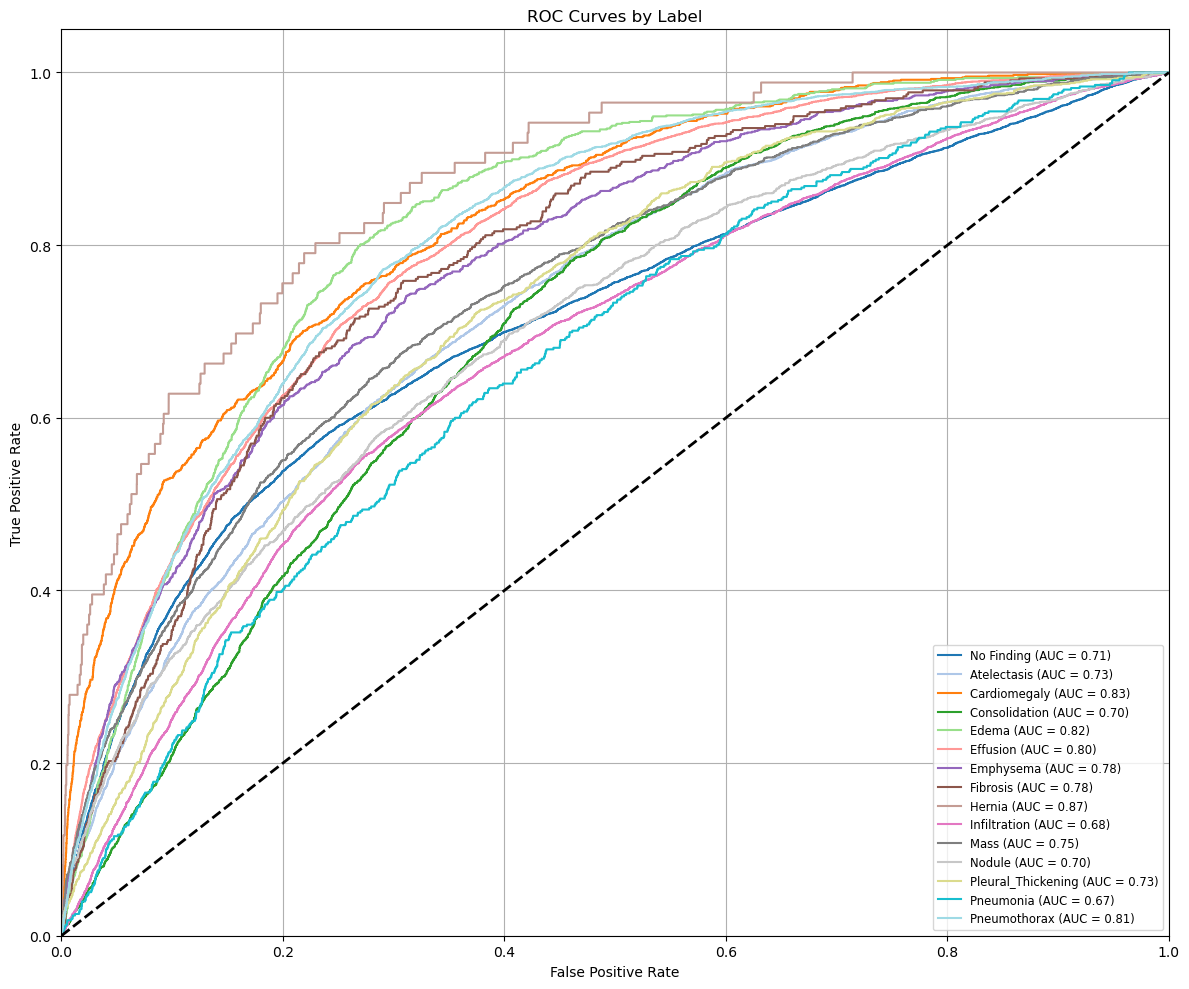

In [13]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

# -----------------------------
# Paths
# -----------------------------
train_csv = "/Users/aysha/Desktop/train.csv"
val_csv = "/Users/aysha/Desktop/val.csv"
test_csv = "/Users/aysha/Desktop/test.csv"
image_dir = "/Users/aysha/Desktop/DL4MED/PROJECT/images"
model_path = "/Users/aysha/Desktop/best_CNN_model.pth"

# -----------------------------
# Load CSVs
# -----------------------------
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Labels
label_names = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
               'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 
               'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# -----------------------------
# Dataset
# -----------------------------
class ChestXrayDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.labels = df[label_names].values

        self.df["Patient Age"] = pd.to_numeric(self.df["Patient Age"], errors="coerce").fillna(0).clip(0, 100) / 100.0
        self.df["Patient Sex"] = self.df["Patient Sex"].map({"M": 0.0, "F": 1.0}).fillna(0.5)
        self.df["View Position"] = self.df["View Position"].map({"PA": 0.0, "AP": 1.0}).fillna(0.5)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.image_dir, row["Image Index"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        metadata = torch.tensor([
            row["Patient Age"],
            row["Patient Sex"],
            row["View Position"]
        ], dtype=torch.float32)

        label = torch.tensor(self.labels[idx]).float()
        return image, metadata, label

# -----------------------------
# Transforms
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -----------------------------
# Load Datasets
# -----------------------------
val_dataset = ChestXrayDataset(val_df, image_dir, transform=transform)
test_dataset = ChestXrayDataset(test_df, image_dir, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -----------------------------
# Model Definition
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(512 + 3, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x, metadata):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, metadata], dim=1)
        x = self.classifier(x)
        return x

# -----------------------------
# Load Model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(label_names)).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate(loader, name="Set"):
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for images, metadata, labels in tqdm(loader, desc=f"Evaluating {name}"):
            images, metadata = images.to(device), metadata.to(device)
            outputs = model(images, metadata)
            y_true.append(labels.cpu().numpy())
            y_probs.append(outputs.cpu().numpy())

    y_true = np.vstack(y_true)
    y_probs = np.vstack(y_probs)
    y_pred = (y_probs >= 0.5).astype(int)

    # === Aggregate Metrics ===
    print(f"\n=== {name} Performance ===")
    for avg in ["micro", "macro", "weighted"]:
        f1 = f1_score(y_true, y_pred, average=avg, zero_division=0)
        precision = precision_score(y_true, y_pred, average=avg, zero_division=0)
        recall = recall_score(y_true, y_pred, average=avg, zero_division=0)
        print(f"{avg.capitalize()} Precision: {precision:.4f}")
        print(f"{avg.capitalize()} Recall:    {recall:.4f}")
        print(f"{avg.capitalize()} F1-score:  {f1:.4f}\n")

    try:
        auc_macro = roc_auc_score(y_true, y_probs, average="macro")
        auc_micro = roc_auc_score(y_true, y_probs, average="micro")
        auc_weighted = roc_auc_score(y_true, y_probs, average="weighted")
    except ValueError:
        auc_macro = auc_micro = auc_weighted = "Undefined (labels missing)"

    print(f"AUC-ROC (Macro):    {auc_macro if isinstance(auc_macro, str) else f'{auc_macro:.4f}'}")
    print(f"AUC-ROC (Micro):    {auc_micro if isinstance(auc_micro, str) else f'{auc_micro:.4f}'}")
    print(f"AUC-ROC (Weighted): {auc_weighted if isinstance(auc_weighted, str) else f'{auc_weighted:.4f}'}")

    exact_match = (y_true == y_pred).all(axis=1).mean()
    print(f"Exact Match Ratio:  {exact_match:.4f}")

    # === Per-label Metrics ===
    print(f"\nPer-label metrics:")
    for idx, label in enumerate(label_names):
        p = precision_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
        r = recall_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
        f1 = f1_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
        print(f"{label}: Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}")

    return y_true, y_probs

# -----------------------------
# Plot ROC Curves (with colormap)
# -----------------------------
def plot_roc_curves(y_true, y_probs, label_names):
    plt.figure(figsize=(12, 10))
    cmap = cm.get_cmap('tab20', len(label_names))

    for i, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=cmap(i))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Label')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plot Loss Curves (optional)
# -----------------------------
def plot_loss_curves(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Run
# -----------------------------
val_y_true, val_y_probs = evaluate(val_loader, name="Validation Set")
test_y_true, test_y_probs = evaluate(test_loader, name="Test Set")

plot_roc_curves(test_y_true, test_y_probs, label_names)

# If you have training loss history:
# plot_loss_curves(train_loss_history, val_loss_history)
